# Телеком

## Описание задачи
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## План работы
1. Разведовательный анализ
    - загрузка данных
    - изучение данных с помощью info, describe
    - приведение к нужным типам данных
2. Исследовательский анализ
    - проверим данные на дубликаты
    - проверим данные на пропуски. Проанализируем вариант работы с ними (замена значением, удаление и т.п)
    - поосмотрим на распределение количественных признаков
    - объединим данные по customerID
    - проработаем аномалии и выбросы
3. Конструирование признаков
    - выделим целевой признак
    - посмотрим распределение числовых признаков
    - проверим корреляцию признаков
    - выделим новый признак "длительность контракта"
    - разделим данные на train и test
    - закодируем категориальные признаки
4. Подбор гиперпараметров. Выбор лучшей модели.
    - LogisticRegression
    - RandomForest
    - CatBoostClassifier
5. Выбор модели
    - проверка модели на test
    - кривая ROC-AUC
6. Вывод
    - результат работы модели
7. Отчет
    - резюме проделанной работы

##### Вопросов нет

### Описание данных
Данные состоят из файлов, полученных из разных источников:

- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.

In [1]:
# import libraries
import pandas as pd
#from pandas_profiling import ProfileReport
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score, roc_curve, confusion_matrix, accuracy_score
from sklearn.linear_model import LogisticRegression

from catboost import CatBoostClassifier

import phik
from phik.report import plot_correlation_matrix

## Разведовательный анализ

In [2]:
try:
    data_contract = pd.read_csv('contract.csv', index_col='customerID')
    data_personal = pd.read_csv('personal.csv', index_col='customerID')
    data_internet = pd.read_csv('internet.csv', index_col='customerID')    
    data_phone = pd.read_csv('phone.csv', index_col='customerID')  
except:
    data_contract = pd.read_csv('/datasets/final_provider/contract.csv', index_col='customerID')
    data_personal = pd.read_csv('/datasets/final_provider/personal.csv', index_col='customerID')
    data_internet = pd.read_csv('/datasets/final_provider/internet.csv', index_col='customerID')    
    data_phone = pd.read_csv('/datasets/final_provider/phone.csv', index_col='customerID') 

### data_contract

In [3]:
data_contract.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


In [4]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(6)
memory usage: 440.2+ KB


In [5]:
data_contract[data_contract.TotalCharges == " "]

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
customerID,,,,,,,
4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,


In [6]:
data_contract.describe()

,MonthlyCharges
count,7043.000000
mean,64.761692
std,30.090047
min,18.250000
25%,35.500000
50%,70.350000
75%,89.850000
max,118.750000


Признаки BeginDate, EndDate и TotalCharges имеют категориальный тип данных. При конструировании признаков BeginDate и EndDate изменим на Timestamp, а TotalCharges на float64. Признак TotalCharges имеет пустые строковые значения. Это пользователи, чьи контракты начались в день выгрузки данных. Их немного, они не повлияют на результат работы. Избавимся от них.

In [7]:
data_contract.TotalCharges = pd.to_numeric(data_contract.TotalCharges, errors='coerce')
data_contract = data_contract.dropna()

In [8]:
data_contract.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7032 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7032 non-null   object 
 1   EndDate           7032 non-null   object 
 2   Type              7032 non-null   object 
 3   PaperlessBilling  7032 non-null   object 
 4   PaymentMethod     7032 non-null   object 
 5   MonthlyCharges    7032 non-null   float64
 6   TotalCharges      7032 non-null   float64
dtypes: float64(2), object(5)
memory usage: 439.5+ KB


### data_personal

In [9]:
data_personal.head()

,gender,SeniorCitizen,Partner,Dependents
customerID,,,,
7590-VHVEG,Female,0,Yes,No
5575-GNVDE,Male,0,No,No
3668-QPYBK,Male,0,No,No
7795-CFOCW,Male,0,No,No
9237-HQITU,Female,0,No,No


In [10]:
data_personal.SeniorCitizen = data_personal.SeniorCitizen.astype('object')

In [11]:
data_personal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   gender         7043 non-null   object
 1   SeniorCitizen  7043 non-null   object
 2   Partner        7043 non-null   object
 3   Dependents     7043 non-null   object
dtypes: object(4)
memory usage: 275.1+ KB


In [12]:
data_personal.describe()

,gender,SeniorCitizen,Partner,Dependents
count,7043,7043,7043,7043
unique,2,2,2,2
top,Male,0,No,No
freq,3555,5901,3641,4933


SeniorCitizen - пенсионер. Значение 1 - True, 0 - False.

### data_internet

In [13]:
data_internet.head()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
customerID,,,,,,,
7590-VHVEG,DSL,No,Yes,No,No,No,No
5575-GNVDE,DSL,Yes,No,Yes,No,No,No
3668-QPYBK,DSL,Yes,Yes,No,No,No,No
7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
9237-HQITU,Fiber optic,No,No,No,No,No,No


In [14]:
data_internet.info()

<class 'pandas.core.frame.DataFrame'>
Index: 5517 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 7 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   InternetService   5517 non-null   object
 1   OnlineSecurity    5517 non-null   object
 2   OnlineBackup      5517 non-null   object
 3   DeviceProtection  5517 non-null   object
 4   TechSupport       5517 non-null   object
 5   StreamingTV       5517 non-null   object
 6   StreamingMovies   5517 non-null   object
dtypes: object(7)
memory usage: 344.8+ KB


In [15]:
data_internet.describe()

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
count,5517,5517,5517,5517,5517,5517,5517
unique,2,2,2,2,2,2,2
top,Fiber optic,No,No,No,No,No,No
freq,3096,3498,3088,3095,3473,2810,2785


Пропусков, подозрительных значений нет. Все признаки - категориальные.

### data_phone

In [16]:
data_phone.head()

,MultipleLines
customerID,
5575-GNVDE,No
3668-QPYBK,No
9237-HQITU,No
9305-CDSKC,Yes
1452-KIOVK,Yes


In [17]:
data_phone.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6361 entries, 5575-GNVDE to 3186-AJIEK
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   MultipleLines  6361 non-null   object
dtypes: object(1)
memory usage: 99.4+ KB


In [18]:
data_phone.describe()

,MultipleLines
count,6361
unique,2
top,No
freq,3390


Пропусков, подозрительных значений нет. Признак MultipleLines - категориальный.

## Исследовательский анализ
В этом разделе:
- проверим данные на дубликаты
- проверим данные на пропуски. Проанализируем вариант работы с ними (замена значением, удаление и т.п)
- поосмотрим на распределение количественных признаков
- объединим данные по customerID
- проработаем аномалии и выбросы

In [19]:
# Объявление констант дата выгрузки и random_state
DOWNLOAD_DATE = pd.to_datetime('2020-02-01')
RANDOM_STATE = 120922

### Объединение таблиц

In [20]:
data = data_contract.join([data_internet, data_personal, data_phone], how='outer')
data = data.reset_index(drop=True)

In [21]:
data.duplicated().sum()

15

In [22]:
data = data.drop_duplicates()
data.duplicated().sum()

0

In [23]:
# Изменение типов данных признаков BeginDate, EndDate, TotalCharges
data.BeginDate = pd.to_datetime(data.BeginDate, errors='ignore')
data.EndDate = pd.to_datetime(data.EndDate, errors='coerce')

## Конструирование признаков
В этом разделе:
- разделим данные на train и test
- выделим целевой признак
- проверим признаки на мультиколлинеарность
- произведем кодирование категориальных признаков
- масштабирование и т.п.

### Целевой признак

In [24]:
data['ContractStoped'] = -(data.EndDate.isna().astype('int') - 1) 

In [25]:
data.head()

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,gender,SeniorCitizen,Partner,Dependents,MultipleLines,ContractStoped
0,2020-01-01,NaT,Month-to-month,Yes,Electronic check,29.85,29.85,DSL,No,Yes,No,No,No,No,Female,0,Yes,No,NaN,0
1,2017-04-01,NaT,One year,No,Mailed check,56.95,1889.50,DSL,Yes,No,Yes,No,No,No,Male,0,No,No,No,0
2,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,DSL,Yes,Yes,No,No,No,No,Male,0,No,No,No,1
3,2016-05-01,NaT,One year,No,Bank transfer (automatic),42.30,1840.75,DSL,Yes,No,Yes,Yes,No,No,Male,0,No,No,NaN,0
4,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,Fiber optic,No,No,No,No,No,No,Female,0,No,No,No,1


### Новый признак "ContrackLifeTime"

In [26]:
data.EndDate = data.EndDate.fillna(pd.to_datetime('2020-02-01'))
data['ContractLifeTime'] = (data.EndDate - data.BeginDate).dt.days

### Удалим BeginDate и EndDate

In [27]:
data = data.drop(columns=['BeginDate', 'EndDate'])

In [28]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7028 entries, 0 to 7041
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7019 non-null   object 
 1   PaperlessBilling  7019 non-null   object 
 2   PaymentMethod     7019 non-null   object 
 3   MonthlyCharges    7019 non-null   float64
 4   TotalCharges      7019 non-null   float64
 5   InternetService   5515 non-null   object 
 6   OnlineSecurity    5515 non-null   object 
 7   OnlineBackup      5515 non-null   object 
 8   DeviceProtection  5515 non-null   object 
 9   TechSupport       5515 non-null   object 
 10  StreamingTV       5515 non-null   object 
 11  StreamingMovies   5515 non-null   object 
 12  gender            7028 non-null   object 
 13  SeniorCitizen     7028 non-null   object 
 14  Partner           7028 non-null   object 
 15  Dependents        7028 non-null   object 
 16  MultipleLines     6346 non-null   object 


Пропуски в столбце InternetService связаны с тем, что клиенты не пользуются интернетом. То же самое можно сказать для столбца MultipleLines. Пропуски в остальных столбцах, вероятно, должны быть "No", но не были заполнены. 

In [29]:
#Удалим записи с пропусками в ContractLifeTime и заполним пропуски "No"
data = data.dropna(subset=['ContractLifeTime'])
data = data.fillna('No')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7019 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7019 non-null   object 
 1   PaperlessBilling  7019 non-null   object 
 2   PaymentMethod     7019 non-null   object 
 3   MonthlyCharges    7019 non-null   float64
 4   TotalCharges      7019 non-null   float64
 5   InternetService   7019 non-null   object 
 6   OnlineSecurity    7019 non-null   object 
 7   OnlineBackup      7019 non-null   object 
 8   DeviceProtection  7019 non-null   object 
 9   TechSupport       7019 non-null   object 
 10  StreamingTV       7019 non-null   object 
 11  StreamingMovies   7019 non-null   object 
 12  gender            7019 non-null   object 
 13  SeniorCitizen     7019 non-null   int64  
 14  Partner           7019 non-null   object 
 15  Dependents        7019 non-null   object 
 16  MultipleLines     7019 non-null   object 


In [30]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7019 entries, 0 to 7031
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7019 non-null   object 
 1   PaperlessBilling  7019 non-null   object 
 2   PaymentMethod     7019 non-null   object 
 3   MonthlyCharges    7019 non-null   float64
 4   TotalCharges      7019 non-null   float64
 5   InternetService   7019 non-null   object 
 6   OnlineSecurity    7019 non-null   object 
 7   OnlineBackup      7019 non-null   object 
 8   DeviceProtection  7019 non-null   object 
 9   TechSupport       7019 non-null   object 
 10  StreamingTV       7019 non-null   object 
 11  StreamingMovies   7019 non-null   object 
 12  gender            7019 non-null   object 
 13  SeniorCitizen     7019 non-null   int64  
 14  Partner           7019 non-null   object 
 15  Dependents        7019 non-null   object 
 16  MultipleLines     7019 non-null   object 


### Распределения числовых признаков

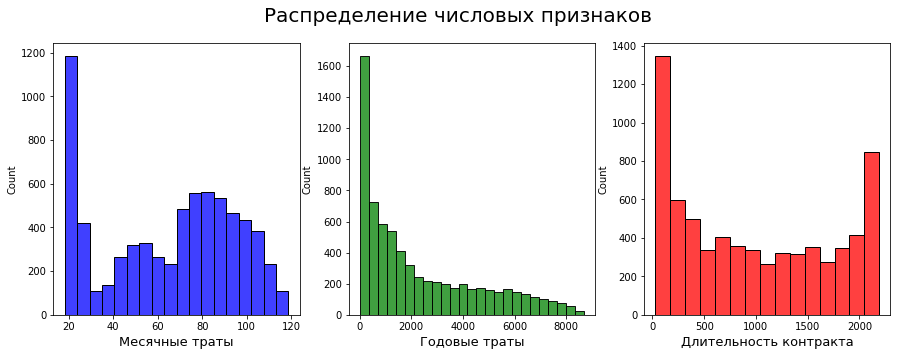

In [39]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Распределение числовых признаков', fontsize=20)
sns.histplot(data=data, x='MonthlyCharges', ax=ax1, color='blue')
sns.histplot(data=data, x='TotalCharges', ax=ax2, color='green')
sns.histplot(data=data, x='ContractLifeTime', ax=ax3, color='red')
ax1.set_xlabel('Месячные траты', fontsize=13)
ax2.set_xlabel('Годовые траты', fontsize=13)
ax3.set_xlabel('Длительность контракта', fontsize=13)
plt.show()

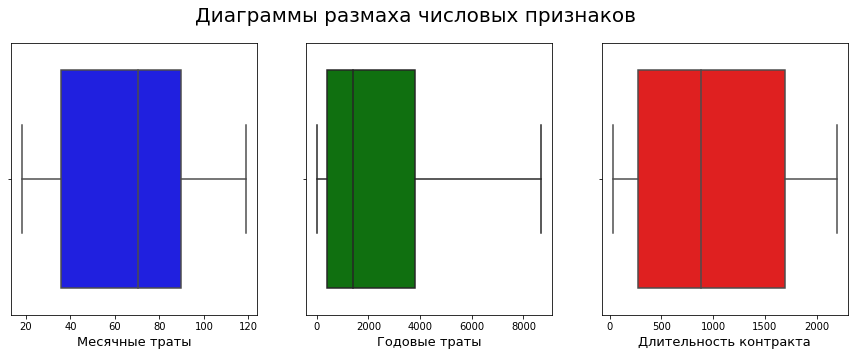

In [40]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
fig.suptitle('Диаграммы размаха числовых признаков', fontsize=20)
sns.boxplot(data=data, x='MonthlyCharges', ax=ax1, color='blue')
sns.boxplot(data=data, x='TotalCharges', ax=ax2, color='green')
sns.boxplot(data=data, x='ContractLifeTime', ax=ax3, color='red')
ax1.set_xlabel('Месячные траты', fontsize=13)
ax2.set_xlabel('Годовые траты', fontsize=13)
ax3.set_xlabel('Длительность контракта', fontsize=13)
plt.show()

<div class="alert alert-warning">
<b>⚠️ Комментарий ревьювера:</b> Хорошая визуализация данных! Было бы интересно также сравнить, как признаки распределены в двух группах — ушедшие и оставшиеся клиенты.
    
Можно в методе histplot добавить параметры hue = 'ContractStoped', multiple = 'stack'
    
https://seaborn.pydata.org/generated/seaborn.histplot.html
    
Таким же образом можно посмотреть и для остальных признаков, или написать цикл, чтобы пройтись по всем признакам.
    
</div>

### Распределение признаков по группам: ушедшие/оставшиеся клинеты

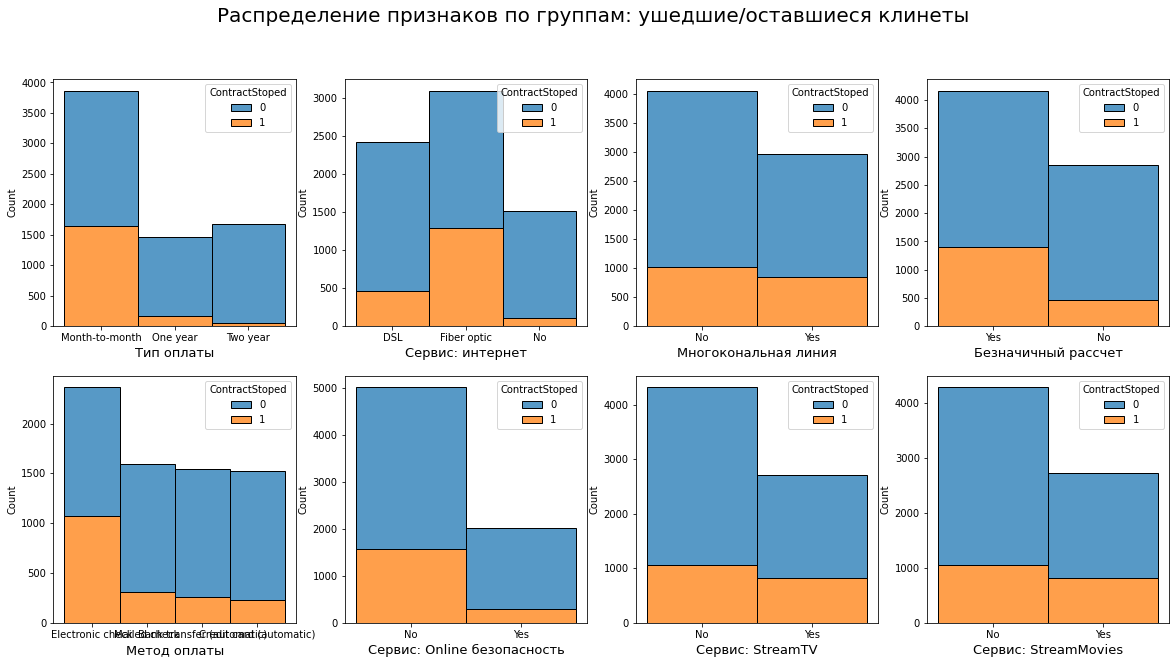

In [41]:
fig, ((ax1, ax2, ax3, ax4), (ax5, ax6, ax7, ax8)) = plt.subplots(2, 4, figsize=(20, 10))
fig.suptitle('Распределение признаков по группам: ушедшие/оставшиеся клинеты', fontsize=20)
sns.histplot(data=data, x='Type', hue='ContractStoped', multiple='stack', ax=ax1)
sns.histplot(data=data, x='InternetService', hue='ContractStoped', multiple='stack', ax=ax2)
sns.histplot(data=data, x='MultipleLines', hue='ContractStoped', multiple='stack', ax=ax3)
sns.histplot(data=data, x='PaperlessBilling', hue='ContractStoped', multiple='stack', ax=ax4)
sns.histplot(data=data, x='PaymentMethod', hue='ContractStoped', multiple='stack', ax=ax5)
sns.histplot(data=data, x='OnlineSecurity', hue='ContractStoped', multiple='stack', ax=ax6)
sns.histplot(data=data, x='StreamingTV', hue='ContractStoped', multiple='stack', ax=ax7)
sns.histplot(data=data, x='StreamingMovies', hue='ContractStoped', multiple='stack', ax=ax8)
ax1.set_xlabel('Тип оплаты', fontsize=13)
ax2.set_xlabel('Сервис: интернет', fontsize=13)
ax3.set_xlabel('Многокональная линия', fontsize=13)
ax4.set_xlabel('Безначичный рассчет', fontsize=13)
ax5.set_xlabel('Метод оплаты', fontsize=13)
ax6.set_xlabel('Сервис: Online безопасность', fontsize=13)
ax7.set_xlabel('Сервис: StreamTV', fontsize=13)
ax8.set_xlabel('Сервис: StreamMovies', fontsize=13)
plt.show()

Из графиков можно заключить, что ушедшие клиенты в основном:
- оплачивали договор помесячно
- пользовались оптиволокном
- использовали безналичный расчет
- использовали электронный чек
- не использовали OnlineSecurity

### Матрица корреляции

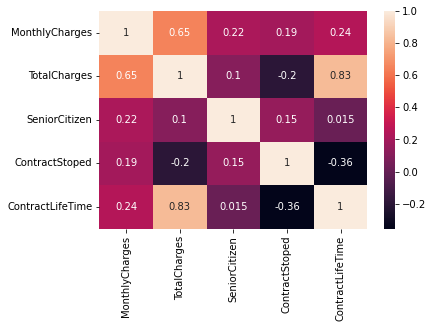

In [34]:
sns.heatmap(data.corr(), annot=True);

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'SeniorCitizen', 'ContractStoped', 'ContractLifeTime']


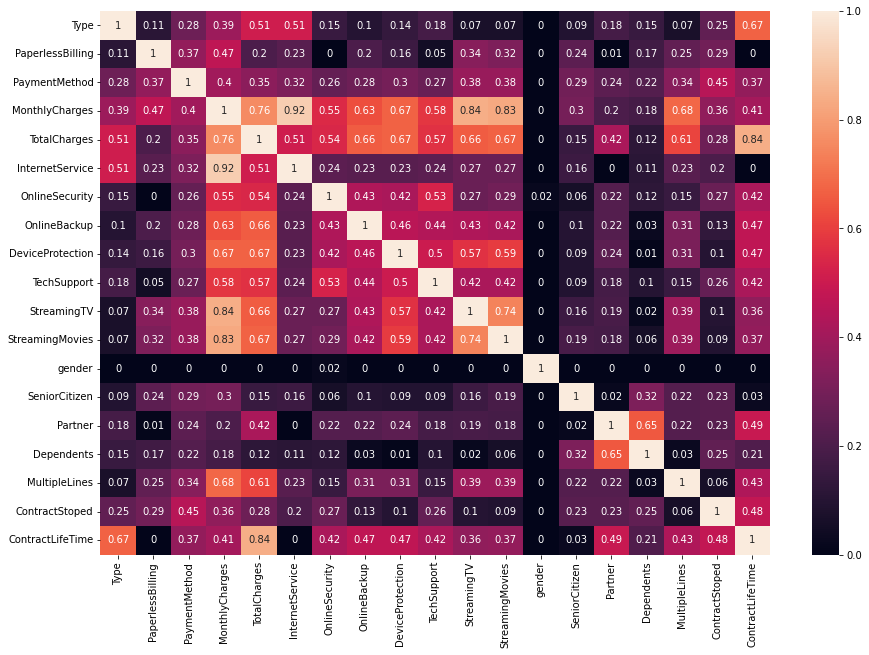

In [35]:
phik_overview = data.phik_matrix()
phik_overview = phik_overview.round(2)
plt.figure(figsize=(15,10))
sns.heatmap(phik_overview, annot=True)
plt.show()

Избавимся от мультиколлениарности. Удолим признаки:
- InternetService - имеет сильную корреляцию с MonthlyCharges
- StreamingTV - имеет сильную корреляцию с MonthlyCharges
- StreamingMovies - имеет сильную корреляцию с MonthlyCharges
- TotalCharges - имеет сильную корреляцию с ContractLifeTime

In [36]:
data = data.drop(columns=['InternetService', 'TotalCharges', 'StreamingTV', 'StreamingMovies'])

In [37]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7019 entries, 0 to 7031
Data columns (total 15 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Type              7019 non-null   object 
 1   PaperlessBilling  7019 non-null   object 
 2   PaymentMethod     7019 non-null   object 
 3   MonthlyCharges    7019 non-null   float64
 4   OnlineSecurity    7019 non-null   object 
 5   OnlineBackup      7019 non-null   object 
 6   DeviceProtection  7019 non-null   object 
 7   TechSupport       7019 non-null   object 
 8   gender            7019 non-null   object 
 9   SeniorCitizen     7019 non-null   int64  
 10  Partner           7019 non-null   object 
 11  Dependents        7019 non-null   object 
 12  MultipleLines     7019 non-null   object 
 13  ContractStoped    7019 non-null   int32  
 14  ContractLifeTime  7019 non-null   float64
dtypes: float64(2), int32(1), int64(1), object(11)
memory usage: 850.0+ KB


### Разделение на train и test. Кодирование категориальных признаков

In [38]:
CATS = ['Type', 'PaperlessBilling', 'PaymentMethod', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
       'TechSupport', 'gender', 'Partner', 'Dependents', 'MultipleLines']

In [39]:
features = data.drop(columns='ContractStoped') 
target = data['ContractStoped']
train, test = train_test_split(data, test_size=0.25, random_state=RANDOM_STATE)

In [40]:
print(train.shape)
print(test.shape)

(5264, 15)
(1755, 15)


In [41]:
# Кодирование категориальных признаков с помощью get_dummies
train = pd.get_dummies(train, columns=CATS, drop_first=True)
test = pd.get_dummies(test, columns=CATS, drop_first=True)

In [42]:
print(train.shape)
print(test.shape)

(5264, 18)
(1755, 18)


In [43]:
features_train = train.drop(columns='ContractStoped')
target_train = train['ContractStoped']
features_test = test.drop(columns='ContractStoped')
target_test = test['ContractStoped']

In [44]:
print(features_train.shape)
print(features_test.shape)
print(target_train.shape)
print(target_test.shape)

(5264, 17)
(1755, 17)
(5264,)
(1755,)


### Проверка идентичности признаков 

In [45]:
features_train.columns

Index(['MonthlyCharges', 'SeniorCitizen', 'ContractLifeTime', 'Type_One year',
       'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes'],
      dtype='object')

In [46]:
features_test.columns

Index(['MonthlyCharges', 'SeniorCitizen', 'ContractLifeTime', 'Type_One year',
       'Type_Two year', 'PaperlessBilling_Yes',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes',
       'TechSupport_Yes', 'gender_Male', 'Partner_Yes', 'Dependents_Yes',
       'MultipleLines_Yes'],
      dtype='object')

Наименование и порядок новых признаков совпадают

## Подбор гиперпараметров. Выбор лучшей модели. 
В этом разделе:
- произведем подбор гиперпараметров нескольких моделей с помощью кросс-валидации
- выберем модель, чьи показатели ROC-AUC лучше остальных на train-выборке
- проверим модель на test-выборке

### LogisticRegression

In [99]:
# Стандартизация данных для линейной модели
scaler = StandardScaler()
scaler.fit(features_train)
logreg_features_train = scaler.transform(features_train)
logreg_features_test = scaler.transform(features_test)

In [100]:
logreg_features_train = pd.DataFrame(logreg_features_train)
logreg_features_test = pd.DataFrame(logreg_features_test)

In [101]:
logreg_features_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16
0,0.545758,2.291677,-0.642007,-0.513974,-0.566235,-1.205378,-0.521644,-0.718421,-0.538405,-0.63069,-0.733677,-0.733677,-0.639231,0.996586,1.031656,-0.654002,-0.863676
1,-1.505878,-0.436362,-0.234573,-0.513974,1.766051,-1.205378,1.917017,-0.718421,-0.538405,-0.63069,-0.733677,-0.733677,-0.639231,0.996586,-0.969316,1.529047,-0.863676
2,1.138342,-0.436362,1.480939,-0.513974,1.766051,0.829615,-0.521644,1.391941,-0.538405,-0.63069,-0.733677,-0.733677,1.564379,0.996586,1.031656,1.529047,1.157841
3,0.935835,-0.436362,1.562694,-0.513974,-0.566235,0.829615,-0.521644,-0.718421,-0.538405,-0.63069,1.362998,1.362998,-0.639231,0.996586,1.031656,-0.654002,1.157841
4,-1.512517,-0.436362,-0.763970,1.945624,-0.566235,0.829615,-0.521644,-0.718421,1.857338,-0.63069,-0.733677,-0.733677,-0.639231,-1.003425,1.031656,1.529047,-0.863676


In [102]:
solver = ['newton-cg', 'lbfgs', 'liblinear']
C = [x/10 for x in range(10, 20, 2)]
max_iter = [x for x in range(500, 1000, 100)]
hyperparameter_grid = {'solver': solver,
    'C': C,
   'max_iter': max_iter,
    }

model = LogisticRegression(random_state = RANDOM_STATE, class_weight='balanced')
random_cv = GridSearchCV(estimator=model,
    param_grid=hyperparameter_grid,
    scoring = 'roc_auc',                           
    cv=5)
random_cv.fit(logreg_features_train, target_train)
best_LogReg = random_cv.best_estimator_
print(best_LogReg)
print(random_cv.best_score_)

LogisticRegression(C=1.4, class_weight='balanced', max_iter=500,
                   random_state=120922)
0.8414199884213028


### RandomForest

In [103]:
criterion = ['gini', 'entropy']
n_estimators = [x for x in range(900, 1001, 100)]
max_depth = [x for x in range(5, 10)]
hyperparameter_grid = {'criterion': criterion,
    'n_estimators': n_estimators,
    'max_depth': max_depth
                      }

model = RandomForestClassifier(random_state = RANDOM_STATE, class_weight='balanced')
random_cv = GridSearchCV(estimator=model,
    param_grid=hyperparameter_grid,
    scoring = 'roc_auc',                           
    cv=5)
random_cv.fit(features_train, target_train)
best_random_forest = random_cv.best_estimator_
print(best_random_forest)
print(random_cv.best_score_)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, n_estimators=1000, random_state=120922)
0.8596429283505191


### CatBoostClassifier

In [52]:
iterations = [x for x in range(200, 300, 100)]
learning_rate = [x/10 for x in range(10, 5, -2)]
depth = [x for x in range(5, 10)]
hyperparameter_grid = {'iterations': iterations,
    'learning_rate': learning_rate,
    'depth': depth
                      }

model = CatBoostClassifier(random_state = RANDOM_STATE)
random_cv = GridSearchCV(estimator=model,
    param_grid=hyperparameter_grid,
    scoring = 'roc_auc',                           
    cv=5)
random_cv.fit(features_train, target_train)
best_cat_boost = random_cv.best_estimator_
print(random_cv.best_params_)
print(random_cv.best_score_)

0:	learn: 0.4471253	total: 1.77ms	remaining: 352ms
1:	learn: 0.4136021	total: 3.94ms	remaining: 391ms
2:	learn: 0.3969135	total: 6.22ms	remaining: 409ms
3:	learn: 0.3885568	total: 8.44ms	remaining: 413ms
4:	learn: 0.3727407	total: 10.9ms	remaining: 424ms
5:	learn: 0.3637734	total: 13.4ms	remaining: 432ms
6:	learn: 0.3574706	total: 15.5ms	remaining: 428ms
7:	learn: 0.3491894	total: 17.5ms	remaining: 420ms
8:	learn: 0.3456791	total: 19.6ms	remaining: 415ms
9:	learn: 0.3412512	total: 22.1ms	remaining: 420ms
10:	learn: 0.3270924	total: 24.7ms	remaining: 425ms
11:	learn: 0.3212718	total: 27.4ms	remaining: 429ms
12:	learn: 0.3107881	total: 31.1ms	remaining: 448ms
13:	learn: 0.3046256	total: 33ms	remaining: 438ms
14:	learn: 0.2991035	total: 34.8ms	remaining: 430ms
15:	learn: 0.2961885	total: 36.6ms	remaining: 421ms
16:	learn: 0.2910372	total: 38.4ms	remaining: 414ms
17:	learn: 0.2866501	total: 40.2ms	remaining: 407ms
18:	learn: 0.2804283	total: 43.4ms	remaining: 414ms
19:	learn: 0.2765995	tot

### Выбор модели
При подборе гипперпараметрров лучший результат у CatBoost. Проверем ее на test-выборке

In [105]:
predictions = best_cat_boost.predict_proba(features_test)[:,1]
roc_auc=roc_auc_score(target_test, predictions)
print(f'Значение roc-auc на test-выборке для CatBoost: {roc_auc}')

Значение roc-auc на test-выборке для CatBoost: 0.9085313950549962


#### кривая roc-auc

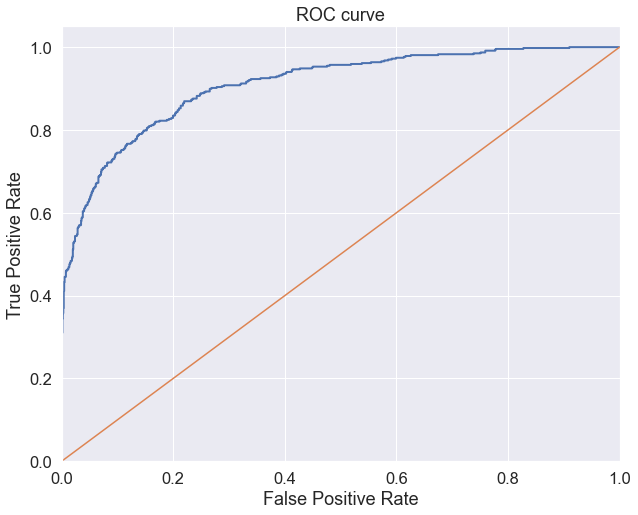

In [106]:
sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(target_test, predictions, pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()

### Вывод
Модель логистической регрессии переобучилась и показала невысокий результат на test-выборке.
Модель CatBoostClassifier показала хороший результат на test-выборке - 0.9085313950549962.

## Отчет
В этом разделе:
- перечислим основные этапы работы и что было сделано
- результат работы лучшей модели на test-выборке

В работе были проведены
1. разведовательный анализ
    - изучены типы данных, максимальные, минимальные, медианные значения
    - столбцы с датами приведены к соответствующему типу
2. исследовательский анализ
    - объеденены таблицы по customerID методом outer. Таким образом мы не потеряли клиентов, пользующихся интернетом, но не пользующихся телефонной связью и наоборот.
    - методом drop_duplicates() удалены дубликаты
3. конструирование признаков
    - выделен целевой признак "ContractStoped". Если имелась запись в столбце EndDate, то клиент "ушел", если нет - клиент пользуется услугами на момент выгрузки данных
    - создан новый признак "ContractLifeTime" - разность между EndDate и BeginDate. Если EndDate не был заполнен, то принимали дату выгрузки данных 2020-02-01
    - удолили признаки BeginDate и EndDate, т.к. они не представляли интереса для обучения модели
    - заполнили пропуски значением "No", т.к. пропущенные значения сведетельствуют о том, что клиент не пользовался той или иной услугой
    - посмотрели на распределения числовых признаков. Среднее значение месячных трат ~70, годовых ~1800, длительности контракта ~900 дней
    - построили гистограммы распредления категориальных признаков по целевому признаку:
        - оплачивали договор помесячно
        - пользовались оптиволокном
        - использовали безналичный расчет
        - использовали электронный чек
        - не использовали OnlineSecurity
    - построили матрицу корреляции числовых и категориальных признаков с целью выявления мультиколлинеарности. Были удалены признаки: 'InternetService', 'TotalCharges', 'StreamingTV', 'StreamingMovies'
    - разделили данные на train и test выборки в соотношении 3:1
    - закодировали категориальные признаки методом get_dummies()
4. подбор гиперпараметров и выбор лучшей модели. Было обучено 3 модели: LogisticRegression, RandomForest, CatBoostClassifier с помощью кроссвалидации.
    - т.к. логистическая регрессия - линейная модель, то все признаки были отмасштабированны
    - результаты обучения моделенй:
        - LogisticRegression(C=1.4, class_weight='balanced', max_iter=500, random_state=120922). ROC-AUC:0.8414199884213028
        - RandomForestClassifier(class_weight='balanced', criterion='entropy', max_depth=8, n_estimators=1000, random_state=120922). ROC-AUC:0.8596429283505191
        - CatBoostClassifier('depth': 5, 'iterations': 200, 'learning_rate': 0.6). ROC-AUC:0.9090330926845553
    - CatBoostClassifier показал лучший результат на train выборке. ROC-AUC=0.9085313950549962 на тестовой выборке
    - построили кривую ROC-AUC

По результатам работы можно сказать, что: 
- отклонения от намеченного плана не было
- при выполнении проекта возникли трудности с кодированием OneHotEncoding(), поэтому было принято решение - использовать get_dummies() с последующей проверкой количества и порядком признаков на train и test выборках
- ключевым шагом можно считать избавление от мультиколлинеарности, что позволило улучшить метрику ROC-AUC на test выборке
- список признаков для обучения: 'MonthlyCharges', 'SeniorCitizen', 'ContractLifeTime', 'Type_One year', 'Type_Two year', 'PaperlessBilling_Yes', 'PaymentMethod_Credit card (automatic)', 'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check', 'OnlineSecurity_Yes', 'OnlineBackup_Yes', 'DeviceProtection_Yes', 'TechSupport_Yes', 'gender_Male', 'Partner_Yes', 'Dependents_Yes', 'MultipleLines_Yes'
- размер тестовой выборки: (1755, 17)